In [1]:
%matplotlib inline

from __future__ import division

import sys
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import math

from collections import OrderedDict

In [2]:
import xpsi

from xpsi import PostProcessing

# choose a seed for the notebook if you want caching to be useful
# and the notebook exactly reproducible
PostProcessing.set_random_seed(0)

from xpsi.global_imports import gravradius
#from nestcheck.plots import getdist_kde

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 0.7.5               |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


### Remember to change the path to the config.ini to the one that is in your local repo

In [4]:
%%capture
from STS_module import main as STS

IOError: /Users/linaissa/Documents/MASTER/Stage/research_stuff/NICER_analyses/PSR+J0030/STS_model/model_data/nsx_H_v171019.out not found.

In [10]:
%tb

IOError: /Users/linaissa/Documents/MASTER/Stage/research_stuff/NICER_analyses/PSR+J0030/STS_model/model_data/nsx_H_v171019.out not found.

In [5]:
STS.likelihood

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
beta: Units of kpc^-2.
column_density: Units of 10^20 cm^-2.

In [6]:
# names of free parameters ordered as in sample files
# NB: the parameter named cos_inclination in the sample files is
#     actually the inclination, but the name is declared here to
#     link it to the inclination parameter in the current API, which
#     is the cos(inclination). We do this because the inclinations
#     on disk will be transformed to cos(inclination) by the
#     CustomPrior.transform() instance method with the argument
#     old_API=True.

# I do not have distance meaning I probably have a prior on of which I was not aware
#'distance', 

STS.names = ['distance', 'mass', 'radius',  'cos_inclination',
             'p__phase_shift','p__super_colatitude', 'p__super_radius', 'p__super_temperature', 'beta',
             'column_density']


# check that the list above has the same order of the parameters as printed in cell 4

In [7]:

# names of derived variables of interest
STS.names += ['compactness']#, 's__transformed_phase']

# the hard bounds imposed above for each parameter
# in some cases, depending on how the prior density
# is constructed, automated population of the
# dictionary below might not yield the required bounds,
# whereas manual population of the dictionary allows
# the user to take full control
STS.bounds = {'distance': (0.235, 0.415),
              'mass': (1.0, 2.5),
              'radius': (3.0 * gravradius(1.0), 16.0),
              'cos_inclination': (0.0, 1.0), #(0.0, math.cos(0.001))
              'p__super_colatitude': (0.001, math.pi/2.0), #0.001, math.pi/2.0 #(0.001, math.pi - 0.001)
              'p__super_radius': (0.001, math.pi/2.0 - 0.001), #0.001, math.pi/2.0 - 0.001
              'p__super_temperature': (5.3, 6.5), #5.1-6.8
              #'s__super_colatitude': (0.001, math.pi - 0.001),
              #'s__super_radius': (0.001, math.pi/2.0 - 0.001),
              #'s__super_temperature': (5.1, 6.8),
              'column_density': (0.0, 1.0), #5
              #'alpha': (0.5,1.5),
              'beta': (0.1,30.0),
              #'gamma': (0.5,1.5),
              'p__phase_shift': (-0.25,0.75),
              #'s__phase_shift': (-0.5,0.5),
              'compactness': (gravradius(1.0)/16.0, 1.0/3.0)}#,
              #'s__transformed_phase': (-1.0,0.0)}

# TeX compatible labels
STS.labels = {'distance': r"D\;\mathrm{[kpc]}",
              'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'cos_inclination': r"\cos(i)",
              'p__super_colatitude': r"\Theta_{p}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{p}\;\mathrm{[rad]}",
              'p__super_temperature': r"\mathrm{log10}(T_{p}\;[\mathrm{K}])",
              #'s__super_colatitude': r"\Theta_{s}\;\mathrm{[rad]}",
              #'s__super_radius': r"\zeta_{s}\;\mathrm{[rad]}",
              #'s__super_temperature': r"\mathrm{log10}(T_{s}\;[\mathrm{K}])",
              'column_density': r"N_{\mathrm{H}}\;\mathrm{[10^{20}\;cm^{-2}]}",
              #'alpha': r"\alpha",
              'beta': r"\beta",
              #'gamma': r"\gamma",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              #'s__phase_shift': r"\phi_{s}\;\mathrm{[cycles]}",
              'compactness': r"M/R_{\mathrm{eq}}"}#,
              #'s__transformed_phase': r"\phi_{s}\;\mathrm{[cycles]}"}

In [8]:
getdist_kde_settings = {'ignore_rows': 0,
                         'min_weight_ratio': 1.0e-10,
                         'contours': [0.683, 0.954, 0.997],
                         'credible_interval_threshold': 0.001,
                         'range_ND_contour': 0,
                         'range_confidence': 0.001,
                         'fine_bins': 1024,
                         'smooth_scale_1D': 0.4,
                         'num_bins': 100,
                         'boundary_correction_order': 1,
                         'mult_bias_correction_order': 1,
                         'smooth_scale_2D': 0.4,
                         'max_corr_2D': 0.99,
                         'fine_bins_2D': 1024,
                         'num_bins_2D': 40}

In [14]:
STS.runs = xpsi.Runs.load_runs(ID='ST-S',
                               run_IDs=['run 4'],#, 'run 2', 'mode separation'],
                               roots=['STS_outputs/run4/run1_nlive1000_eff0.3_noCONST_noMM_noIS_tol-1'#,
                                      #'run2/run2_nlive1000_eff0.3_noCONST_noMM_noIS_tol-3',
                                      #'run3/run1_nlive1000_eff0.3_noCONST_MM_tol-1'
                                     ],
                               base_dirs=['../STS_fromCartesius/'],# * 3,
                               use_nestcheck=[True],#,True,False],#?
                               kde_settings=getdist_kde_settings,
                               likelihood=STS.likelihood,
                               names=STS.names,
                               bounds=STS.bounds,
                               labels=STS.labels,
                               implementation='multinest',
                               overwrite_transformed=True)

IndexError: tuple index out of range

In [17]:
data = np.loadtxt('STS_outputs/run3/run1_nlive1000_eff0.3_noCONST_noMM_noIS_tol-1.txt')

IOError: STS_outputs/run3/run1_nlive1000_eff0.3_noCONST_noMM_noIS_tol-1.txt not found.

In [38]:
print (np.shape(data)) #(49392, 11)

(1000, 11)


In [39]:
p = [1.4,
     12.5,
     math.cos(137.496),
     0.0,
     1.0,
     0.15,
     6.2,
     15.0,
    1.0]

STS.likelihood.clear_cache()
STS.likelihood(p, reinitialise=True)

-5.939321535345923e+89

In [40]:
p = [2.1,15.5,0.5,-0.05,1.35,0.015,6.3,15.0,1.0]
STS.likelihood.check(None, [-4.08535176e+04], 1.0e-5, physical_points=[p])

Checking likelihood and prior evaluation before commencing sampling...
Cannot import ``allclose`` function from NumPy.
Using fallback implementation...
Checking closeness of likelihood arrays:
-4.06187000e+04 | -4.08535176e+04 .....
Closeness evaluated.


ValueError: Log-likelihood value checks failed on process 0

In [41]:
pp = xpsi.PostProcessing.CornerPlotter([STS.runs])

In [42]:
#import nestcheck.
#nestcheck.plots.__file__
from nestcheck.plots import getdist_kde

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['radius', 'compactness']
plotting:  ['radius', 'mass']
plotting:  ['compactness', 'mass']
Adding 1D marginal prior density functions...
Plotting prior for posterior ST-S...
Drawing samples from the joint prior...
Samples drawn.
Estimating 1D marginal KL-divergences in bits...
radius KL-divergence = 0.2665...
compactness KL-divergence = inf...
mass KL-divergence = 0.1623...
Estimated 1D marginal KL-divergences.
Added 1D marginal prior density functions.
Veneering spines and axis ticks...
Veneered.
Adding 1D marginal credible intervals...
Plotting credible regions for posterior ST-S...
Added 1D marginal credible intervals.
Constructed lower-triangle posterior density plot.
Posterior density estimation complete.


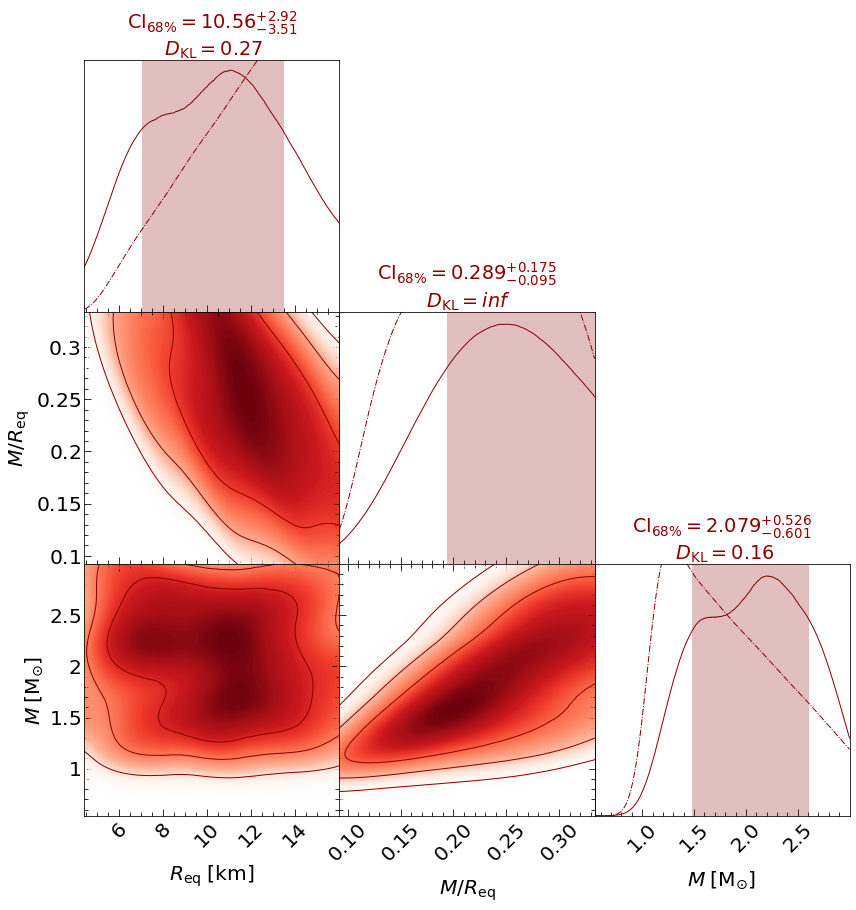

In [43]:
_ = pp.plot(
     params=['radius','compactness','mass'],
     IDs=OrderedDict([('ST-S', ['run 2',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=True, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},#'radius': (7.5,16.0)},#, 'mass': (1.0,3.0)
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STS_spacetime',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1)

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['radius', 'mass']
plotting:  ['radius', 'cos_inclination']
plotting:  ['radius', 'p__super_colatitude']
plotting:  ['radius', 'p__phase_shift']
plotting:  ['radius', 'p__super_radius']
plotting:  ['radius', 'p__super_temperature']
plotting:  ['mass', 'cos_inclination']
plotting:  ['mass', 'p__super_colatitude']
plotting:  ['mass', 'p__phase_shift']
plotting:  ['mass', 'p__super_radius']
plotting:  ['mass', 'p__super_temperature']
plotting:  ['cos_inclination', 'p__super_colatitude']
plotting:  ['cos_inclination', 'p__phase_shift']
plotting:  ['cos_inclination', 'p__super_radius']
plotting:  ['cos_inclination', 'p__super_temperature']
plotting:  ['p__super_colatitude', 'p__phase_shift']
plotting:  ['p__super_colatitude', 'p__super_radius']
plotting:  ['p__super_colatitude', 'p__super_temperature']
plott

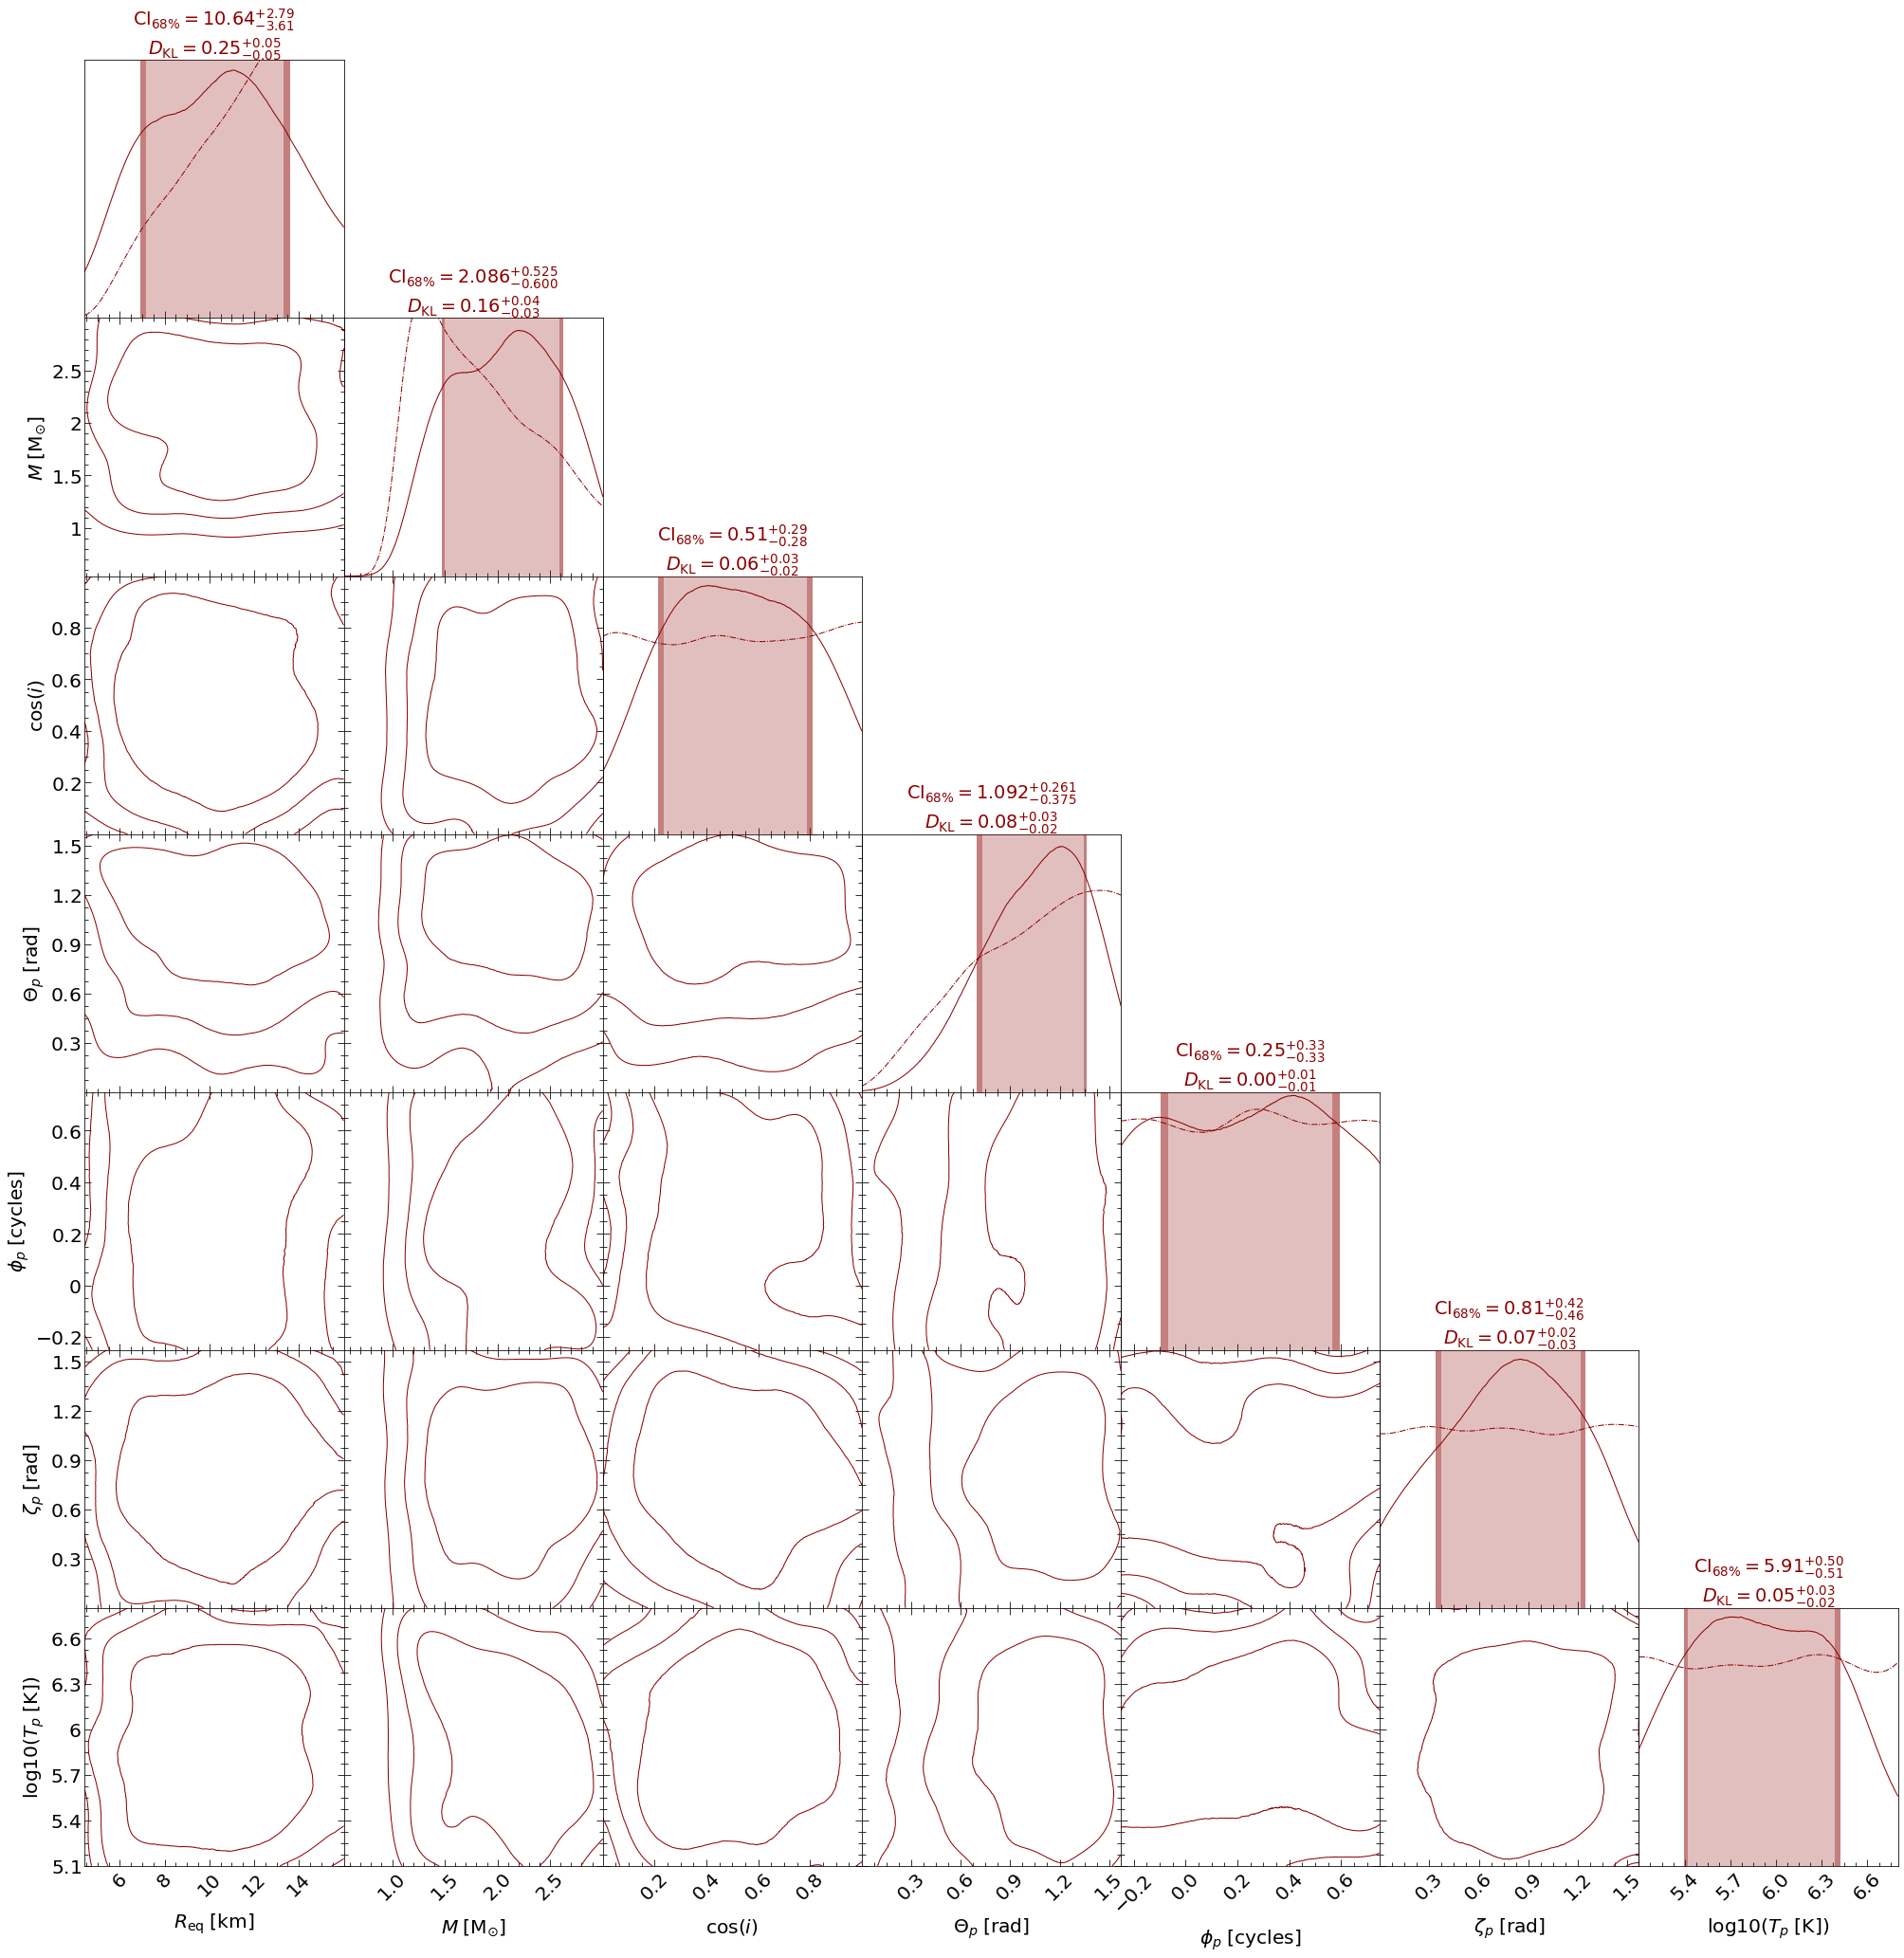

In [45]:
_ = pp.plot(
     params=['radius','mass','cos_inclination',
             'p__super_colatitude',
             'p__phase_shift',
             'p__super_radius',
             'p__super_temperature'],
             #'s__super_temperature',],
     IDs=OrderedDict([('ST-S', ['run 2',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=1e4,
     combine=True, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},#'radius': (7.5,16.0), 'mass': (1.0,2.0)},
     bootstrap_estimators=True,
     bootstrap_density=False,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STS_source',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)

In [46]:
"""
_ = pp.plot(
     params=['radius','compactness','mass'],
     IDs=OrderedDict([('ST-S', ['run 1',])]),
     prior_density=True,
     KL_divergence=True,
     ndraws=5e4,
     combine=True, combine_all=False, only_combined=False,
     param_plot_lims={},#'radius': (7.5,16.0), 'mass': (1.0,2.0)},
     bootstrap_estimators=True,
     bootstrap_density=True,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STS_density_noise',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.625,0.65),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 4.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=0.25,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)
"""

"\n_ = pp.plot(\n     params=['radius','compactness','mass'],\n     IDs=OrderedDict([('ST-S', ['run 1',])]),\n     prior_density=True,\n     KL_divergence=True,\n     ndraws=5e4,\n     combine=True, combine_all=False, only_combined=False,\n     param_plot_lims={},#'radius': (7.5,16.0), 'mass': (1.0,2.0)},\n     bootstrap_estimators=True,\n     bootstrap_density=True,\n     crosshairs=False,\n     write=False,\n     ext='.png',\n     maxdots=3000,\n     root_filename='STS_density_noise',\n     credible_interval_1d=True,\n     annotate_credible_interval=True,\n     compute_all_intervals=False,\n     sixtyeight=True,\n     x_label_rotation=45.0,\n     num_plot_contours=3,\n     subplot_size=4.0,\n     legend_corner_coords=(0.625,0.65),\n     legend_frameon=False,\n     scale_attrs=OrderedDict([('legend_fontsize', 4.0),\n                              ('lab_fontsize', 1.35),\n                              ('axes_fontsize', 'lab_fontsize'),\n                             ]\n                  

In [47]:
pp = xpsi.SignalPlotter([STS.runs])

In [48]:
xpsi.ResidualPlot.declare_settings(extension='.png')

Declaring plot class settings...
Settings declared.


In [25]:
# mass: Gravitational mass [solar masses].
# radius: Coordinate equatorial radius [km].
# cos_inclination: Cosine of Earth inclination to rotation axis.
# p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
# p__super_colatitude: The colatitude of the centre of the superseding region [radians].
# p__super_radius: The angular radius of the (circular) superseding region [radians].
# p__super_temperature: log10(superseding region effective temperature [K]).
# beta: Units of kpc^-2.
# column_density: Units of 10^20 cm^-2.
    

In [49]:
p = [1.4,
     12.5,
     math.cos(137.496),
     0.0,
     1.0,
     0.15,
     6.2,
     10.0,
    1.0]

STS.likelihood.clear_cache()
STS.likelihood(p, reinitialise=True)

-5.939321535345923e+89

Declaring plot class settings...
Settings declared.
Instantiating a residual plotter for posterior checking...
Residual plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST-S...
Weights renormalized to sum to unity.
Checking whether an existing cache can be read:
Creating new cache file...
Initialising cache file...
Cache file initialised.
Cache file created.
Cache state determined.


Signal caching loop:   0%|          | 0/200 [00:00<?, ?it/s]

ResidualPlot object iterating over samples...
ResidualPlot object finished iterating.
ResidualPlot object finalizing...
ResidualPlot object finalized.
Writing plot to disk...
ResidualPlot instance plot will be written to path ./ST-S.run_2__signalplot_residuals.png...
Written.
Handled posterior ST-S.
Plotted signals for posterior checking.


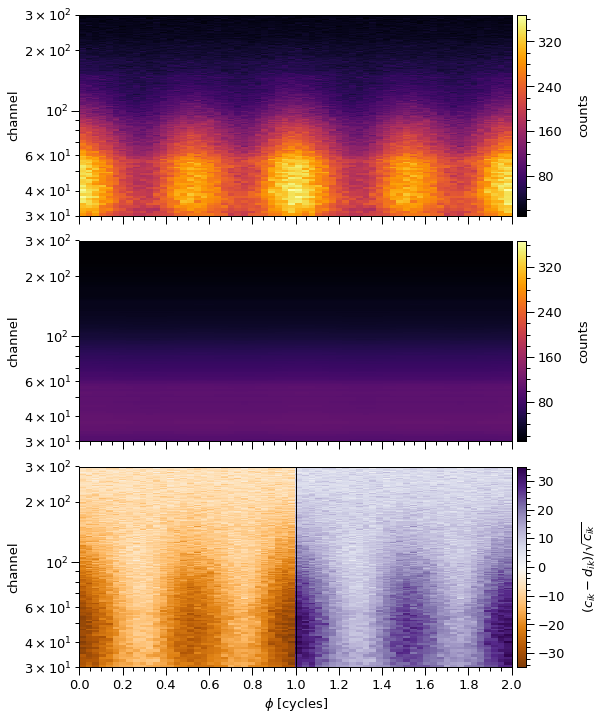

In [51]:
pp = xpsi.SignalPlotter([STS.runs])
xpsi.ResidualPlot.declare_settings(extension='.png')
pp.plot(IDs=OrderedDict([('ST-S', ['run 2',]),
                        ]),
        combine=False, # use these controls if more than one run for a posterior
        combine_all=False,
        force_combine=False,
        only_combined=False,
        nsamples=200,
        plots = {'ST-S': xpsi.ResidualPlot()})

pp.plots['ST-S'].fig

In [52]:
data = np.genfromtxt('STS_outputs/run2/run1_nlive1000_eff0.3_noCONST_noMM_noIS_tol-1.txt')


In [53]:
print (np.shape(data))

(1000, 11)


In [54]:
xpsi.PulsePlot.declare_settings(extension='.png')

Declaring plot class settings...
Settings declared.


Instantiating a pulse-profile plotter for posterior checking...
Pulse-profile plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST-S...
Weights renormalized to sum to unity.
Checking whether an existing cache can be read:
Creating new cache file...
Initialising cache file...
Cache file initialised.
Cache file created.
Cache state determined.


Signal caching loop:   0%|          | 0/200 [00:00<?, ?it/s]

PulsePlot object iterating over samples...
PulsePlot object finished iterating.
PulsePlot object finalizing...
PulsePlot object finalized.
Writing plot to disk...
PulsePlot instance plot will be written to path ./ST-S.run_2__signalplot_pulse.png...
Written.
Handled posterior ST-S.
Plotted signals for posterior checking.


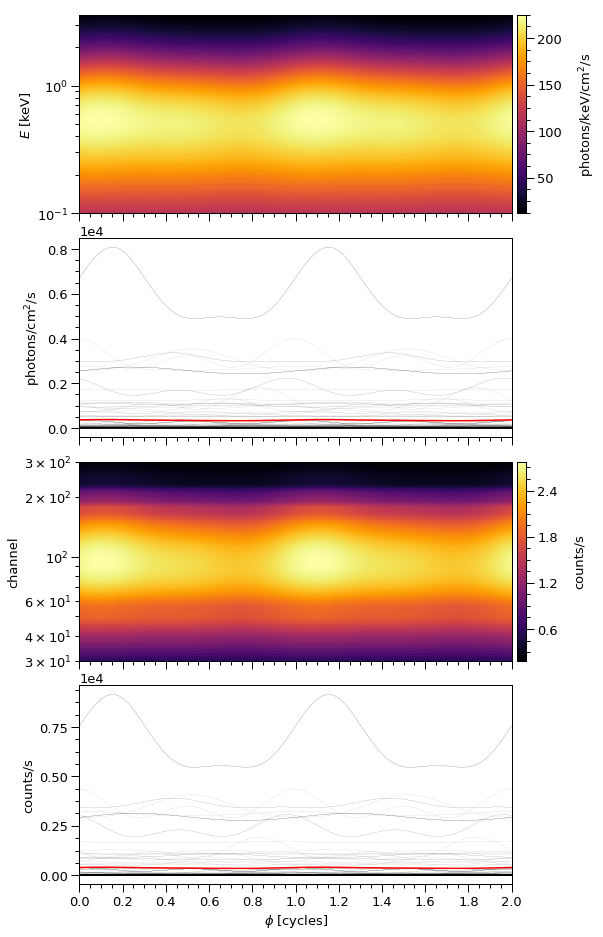

In [55]:
pp.plot(IDs=OrderedDict([ ('ST-S', ['run 2',]),
                        ]),
        nsamples=200,
        plots = {'ST-S': xpsi.PulsePlot(expectation_line_kwargs=dict(color='red'))})

pp.plots['ST-S'].fig

Instantiating a spectrum plotter for posterior checking...
Declaring plot class settings...
Settings declared.
Spectrum plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST-S...
Weights renormalized to sum to unity.
Checking whether an existing cache can be read:
Creating new cache file...
Initialising cache file...
Cache file initialised.
Cache file created.
Cache state determined.


Signal caching loop:   0%|          | 0/200 [00:00<?, ?it/s]

SpectrumPlot object iterating over samples...
SpectrumPlot object finished iterating.
SpectrumPlot object finalizing...
SpectrumPlot object finalized.
Writing plot to disk...
SpectrumPlot instance plot will be written to path ./ST-S.run_2__signalplot_spectrum.pdf...
Written.
Handled posterior ST-S.
Plotted signals for posterior checking.


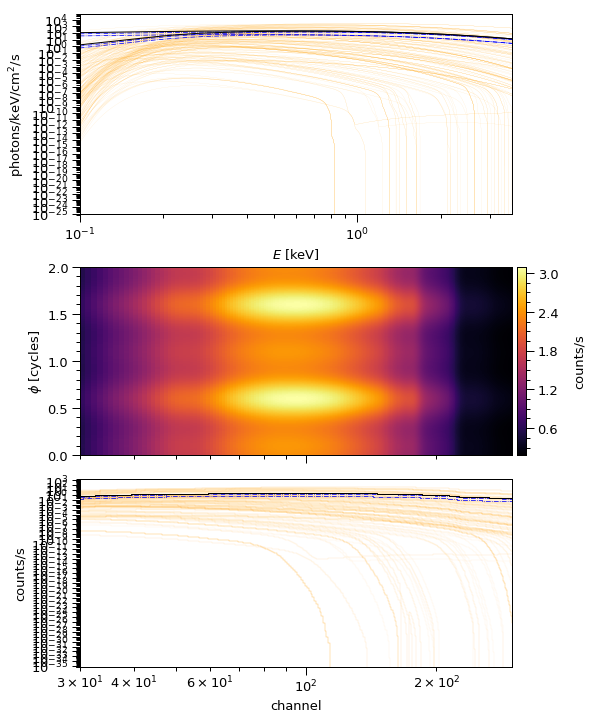

In [56]:
pp.plot(IDs=OrderedDict([ ('ST-S', ['run 2',]),
                        ]),
        nsamples=200,
        plots = {'ST-S': xpsi.SpectrumPlot(expectation_line_kwargs=dict(color='k',
                                                                          ls='-',
                                                                          lw=1.0,
                                                                          alpha=1.0),
                                             sample_line_kwargs=dict(color='orange',
                                                                     ls='-',
                                                                     lw=0.05,
                                                                     alpha=1.0),
                                             comp_expectation_line_kwargs=dict(color='b',
                                                                            ls='-.',
                                                                            lw=0.75,
                                                                            alpha=1.0),
                                             show_attenuated=True,
                                             show_components=True)})

pp.plots['ST-S'].fig


In [57]:
np.cos(1.23)

0.3342377271245026

In [ ]:

pp = xpsi.PostProcessing.CornerPlotter([STS.runs])

_ = pp.plot(
     params=['radius','mass','cos_inclination',
             'p__super_colatitude',
             'p__phase_shift',
             'p__super_radius',
             'p__super_temperature'],
             #'s__super_temperature',],
     IDs=OrderedDict([('ST-S', ['run 2',]),]),
     prior_density=True,
     KL_divergence=True,
     ndraws=1e4,
     combine=True, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},#'radius': (7.5,16.0), 'mass': (1.0,2.0)},
     bootstrap_estimators=True,
     bootstrap_density=True,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='STS_source',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     x_label_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('lab_fontsize', 1.35),
                              ('axes_fontsize', 'lab_fontsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500,
     scale_ymax=1.1,
     n_simulate=200
)

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['radius', 'mass']
plotting:  ['radius', 'cos_inclination']
plotting:  ['radius', 'p__super_colatitude']
plotting:  ['radius', 'p__phase_shift']
plotting:  ['radius', 'p__super_radius']
plotting:  ['radius', 'p__super_temperature']
plotting:  ['mass', 'cos_inclination']
plotting:  ['mass', 'p__super_colatitude']
plotting:  ['mass', 'p__phase_shift']
plotting:  ['mass', 'p__super_radius']
plotting:  ['mass', 'p__super_temperature']
plotting:  ['cos_inclination', 'p__super_colatitude']
plotting:  ['cos_inclination', 'p__phase_shift']
plotting:  ['cos_inclination', 'p__super_radius']
plotting:  ['cos_inclination', 'p__super_temperature']
plotting:  ['p__super_colatitude', 'p__phase_shift']
plotting:  ['p__super_colatitude', 'p__super_radius']
plotting:  ['p__super_colatitude', 'p__super_temperature']
plott